In [38]:
# Load Depedencies

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
import matplotlib.pyplot as plt

### Hyperparameters

In [39]:
model_name = "VGG"
version = "v1"
training_name = "AT_TPGD"
num_classes = 7
batch_size = 32
learning_rate = 0.0001
lr_factor = 0.1
lr_threshold = 5
epochs = 100
height = 224

epsilon = 8.0/255
alpha = 2.0/255
steps = 10

In [40]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Graph writer initialize
writer = SummaryWriter("runs/trashbox/" + f'{training_name}--{model_name}.{version}')

### Preprocessing

In [41]:
preprocessing = transforms.Compose([
    transforms.RandomResizedCrop((height, height)),
    transforms.ToTensor()
])

### Dataset

In [42]:
trash_train_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/train', transform=preprocessing)
trash_train_loader = torch.utils.data.DataLoader(dataset=trash_train_dataset, shuffle=True, batch_size=batch_size)
trash_val_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/val', transform=preprocessing)
trash_val_loader = torch.utils.data.DataLoader(dataset=trash_val_dataset, shuffle=True, batch_size=batch_size)

### Model

In [43]:
# Setup model
model = models.vgg16()

model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
)

## Enable if will be using pre-trained model
# checkpoint = torch.load('./best_trained_models/best_NORMAL--VGG16.v1_epoch49.pth')

# if 'module' in list(checkpoint['net'].keys())[0]:
#     new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['net'].items()}
#     model.load_state_dict(new_state_dict)
# else:
#     model.load_state_dict(checkpoint['net'])

model = model.to(device)

### Attack; Criterion

In [44]:
atk = torchattacks.TPGD(model, epsilon, alpha, steps)
criterion = nn.CrossEntropyLoss()

### Preview of image

tensor(1.)
tensor(0.)


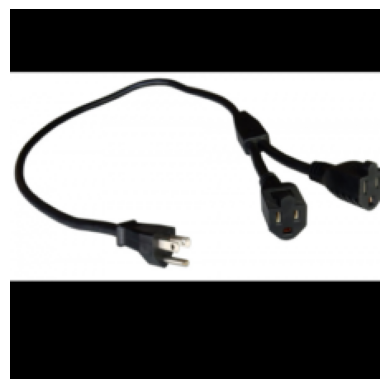

In [45]:
examples = iter(trash_val_loader)
samples, labels = next(examples)

if samples.ndim > 3:
    new_samples = samples.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if samples.ndim == 4:
    new_samples = samples[0]
image_array = new_samples.permute(1, 2, 0).numpy()

# Show min and max values for normalization
print(torch.max(samples))
print(torch.min(samples))

plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

### Preview of Adversarial sample

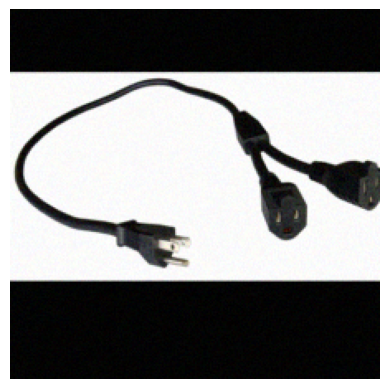

In [46]:
adv_image = atk(samples, labels)
adv_image = adv_image.cpu().detach()

if adv_image.ndim > 3:
    new_adv_samples = adv_image.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if adv_image.ndim == 4:
    new_adv_samples = adv_image[0]
image_array = new_adv_samples.permute(1, 2, 0).numpy()
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

In [47]:
def train(epoch, optimizer): 
    print(f'Train epoch no. [{epoch}]')
    train_loss = 0
    correct = 0
    total = 0
    model.train()
    iterator = tqdm(trash_train_loader, ncols=0, leave=False)
    for i, (inputs, targets)in enumerate(iterator):
        inputs, targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad()

        adv_sample = atk(inputs, targets)
        adv_output = model(adv_sample)
        loss = criterion(adv_output, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = adv_output.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    validation_loss = train_loss / len(trash_train_loader)
    print('\nTotal train accuarcy:', 100. * correct / total)
    print('Validation loss:', validation_loss)
    print('Total train loss:', train_loss)
    
    writer.add_scalar('Adversarial Train loss: ' + model_name, validation_loss, epoch)
    writer.add_scalar('Adversarial Train accuracy: ' + model_name, 100. * correct / total, epoch)
    return train_loss

In [48]:
import torch.utils


best_loss = float('inf')

def test(epoch, optimizer):
    print('\n[ Test epoch: %d ]' % epoch)
    global best_loss
    model.eval()
    benigh_loss = 0
    adv_loss = 0
    adv_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        iterator = tqdm(trash_val_loader, ncols=0, leave=False)
        for i, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)
            # For clean images
            output = model(inputs)
            clean_loss = criterion(output, targets)
            benigh_loss += clean_loss.item()

            _, predicted = output.max(1)
            correct += predicted.eq(targets).sum().item()
            ## For adversarial 
            with torch.enable_grad(): 
                adv_image = atk(inputs, targets)
            adv_image = adv_image.to(device)
            adv_outputs = model(adv_image)
            adv_loss = criterion(adv_outputs, targets)
            adv_loss += adv_loss.item()

            _, adv_predicted = adv_outputs.max(1)
            adv_correct += adv_predicted.eq(targets).sum().item()

    benign_validation_loss = benigh_loss / len(trash_val_loader)
    adv_validation_loss = benigh_loss / len(trash_val_loader)
    benign_accuracy = correct / total
    adv_accuracy = adv_correct / total

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test loss:', benign_validation_loss)
    print('\nTest accuarcy:', 100. * adv_correct / total)
    print('Test loss:', adv_validation_loss)

    # Graph
    writer.add_scalar("Test accuracy: " + model_name, 100. * benign_accuracy, epoch)
    writer.add_scalar("Test loss: " + model_name, benign_validation_loss, epoch)
    writer.add_scalar("Adversarial Test accuracy: " + model_name, 100. * adv_accuracy, epoch)
    writer.add_scalar("Adversarial Test loss: " + model_name, adv_validation_loss, epoch)

    # Save checkpoint
    state = {
        'epoch' : epoch,
        'net': model.state_dict(),
        'optim' : optimizer.state_dict(),
        'loss' : adv_loss
    }

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + f'{training_name}--{model_name}.{version}.pth')
    print('Model Saved!')

    if benign_validation_loss < best_loss:
        print(f'New best loss saved: {benign_validation_loss}')
        best_loss = benign_validation_loss
        torch.save(state, './trained_model/' + f'best_{training_name}--{model_name}.{version}_epoch{epoch}.pth')
    return benign_accuracy, adv_accuracy, benign_validation_loss, adv_validation_loss

In [49]:
def main():
    global learning_rate
    learning_rate = learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=lr_threshold, factor=0.1)

    model_path = f'./checkpoint/{training_name}--{model_name}.{version}.pth'
    if os.path.exists(model_path):
        # Load the saved model and optimizer state
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        optimizer.load_state_dict(checkpoint['optim'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{model_path}' (epoch {start_epoch})")
    else:
        start_epoch = 0
        print(f"=> No checkpoint found at '{model_path}'. Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        train_loss = train(epoch, optimizer)
        _, _, benign_validation_loss, _ = test(epoch, optimizer)
        scheduler.step(metrics=benign_validation_loss, epoch=epoch)
        scheduler.print_lr(True, model.parameters(), learning_rate, epoch)


In [50]:
if __name__ == '__main__':
    main()

=> Loaded checkpoint './checkpoint/AT_TPGD--VGG.v1.pth' (epoch 7)
Train epoch no. [7]


  0% 0/447 [00:00<?, ?it/s]c:\Users\Acer\.conda\envs\thesisaimodel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 394.00 MiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\Acer\.conda\envs\thesisaimodel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 886.00 MiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 